In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from functions_3 import load_and_clean_data, save_clean_data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from joblib import dump


# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# Guardar el dataframe limpio en un archivo CSV
save_clean_data(df, 'data/clean/cleaned_data.csv')

# Imprimir un resumen estadístico
print("Resumen estadístico:")
print(df.describe())

Resumen estadístico:
               year       country      iso_code    population           gdp  \
count  21812.000000  2.181200e+04  2.181200e+04  21812.000000  2.181200e+04   
mean    1974.195718  1.667880e-16  1.667880e-16      0.000000  1.042425e-17   
std       35.342860  1.000023e+00  1.000023e+00      1.000023  1.000023e+00   
min     1900.000000 -1.694203e+00 -1.785087e+00     -0.245677 -1.652175e-01   
25%     1946.000000 -8.932250e-01 -9.105355e-01     -0.239639 -1.507380e-01   
50%     1984.000000  6.194821e-04  1.389259e-01     -0.221922  2.367735e-17   
75%     2004.000000  8.480305e-01  1.107660e+00     -0.012264  2.367735e-17   
max     2023.000000  1.707050e+00  1.174933e+00     18.506549  5.030924e+01   

       electricity_demand  electricity_generation  electricity_share_energy  \
count        2.181200e+04            2.181200e+04              2.181200e+04   
mean         5.212123e-18           -2.736365e-17             -2.353274e-15   
std          1.000023e+00     

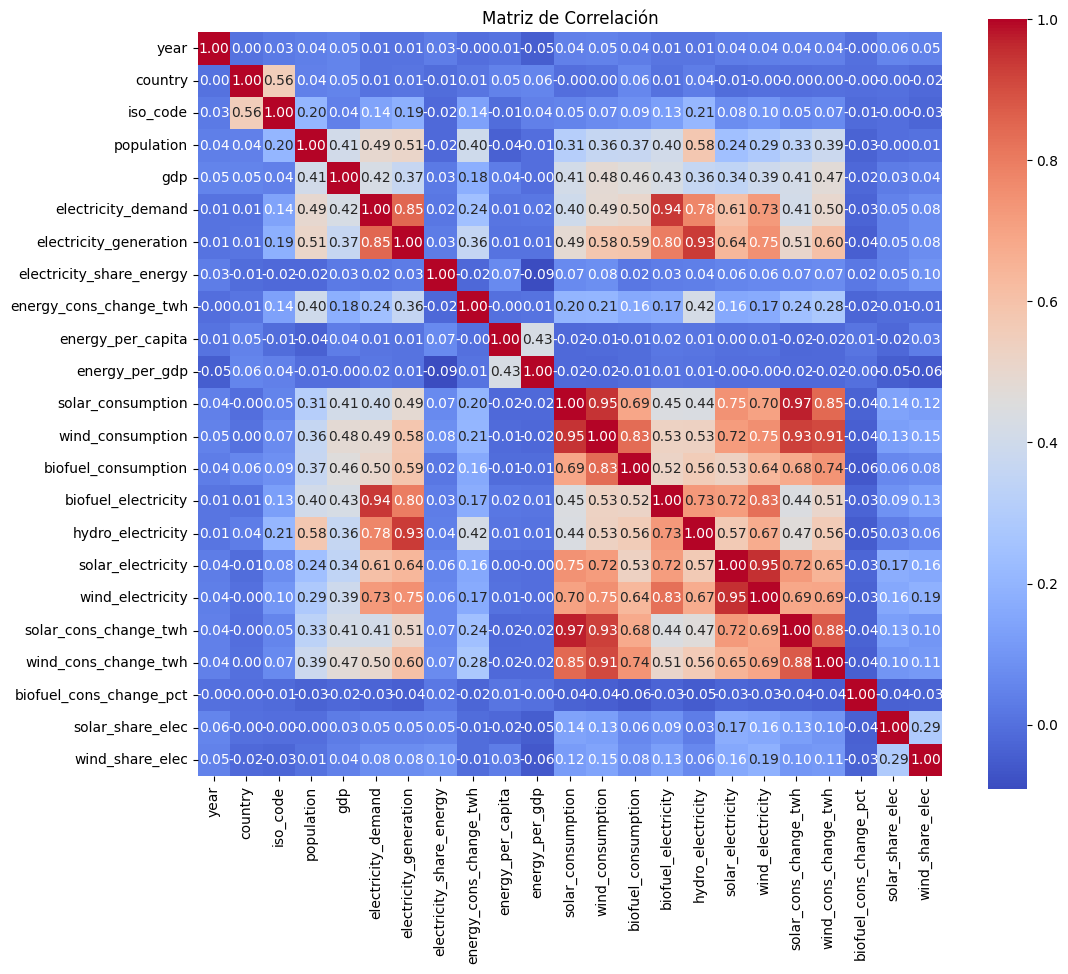

In [3]:
#2. Matriz de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

In [4]:
# 3. Separar características y variables objetivo
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

In [5]:
# 4. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# 5. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))


In [7]:
# 6. Entrenar el modelo
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [8]:
# 7. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

Predicciones completas:
      solar_electricity  wind_electricity  hydro_electricity  \
0         -4.727270e-17          0.000000      -5.899983e-17   
1         -4.727270e-17          0.000000      -5.899983e-17   
2         -4.727270e-17          0.000000      -5.899983e-17   
3         -4.727270e-17          0.000000      -4.178558e-01   
4         -2.181491e-01         -0.273044      -4.709563e-01   
5         -2.181491e-01         -0.278477      -5.001555e-01   
6         -2.181491e-01         -0.278477      -4.972321e-01   
7         -4.727270e-17          0.000000      -5.899983e-17   
8         -4.727270e-17          0.000000      -5.899983e-17   
9         -2.181491e-01         -0.278477      -4.764110e-01   
10        -2.181491e-01         -0.278477      -4.352992e-01   
11        -4.727270e-17          0.000000      -5.899983e-17   
12        -4.727270e-17          0.000000      -5.899983e-17   
13        -2.168539e-01         -0.125946      -4.711234e-01   
14        -4.727

In [9]:
# 8. Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

MAE: 0.01, RMSE: 0.12, R²: 0.99


c:\Users\Carlos\.ai-navigator\conda\envs\ml-project\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# 9. Ajustar el GridSearch para pruebas más rápidas
param_grid = {
    'estimator__n_estimators': [50, 100],  # Reducido para acelerar
    'estimator__max_depth': [None, 10],
    'estimator__min_samples_split': [2]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


Mejores parámetros: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
MAE (Mejor Modelo): 0.0145


In [11]:
# 10. Validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE (Validación Cruzada): {-cv_scores.mean():.4f}")


MAE (Validación Cruzada): 0.0535


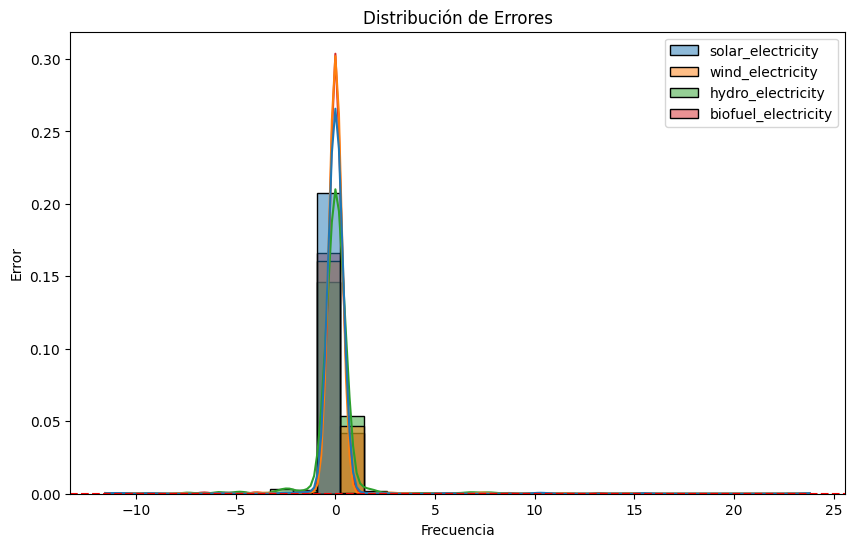

In [31]:
# 11. Analizar la distribución de errores

# Calcular los errores
errors = y_test - y_pred

# Crear la gráfica con errores en el eje Y
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, stat='density', color='blue')  # Agrega 'stat' para densidad
plt.title('Distribución de Errores')
plt.ylabel('Error')  # Cambiar el eje Y a "Error"
plt.xlabel('Frecuencia')  # Cambiar el eje X a "Frecuencia"
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.show()


Top 10 características más importantes:
                        Importance
solar_consumption         0.345799
electricity_generation    0.201314
electricity_demand        0.139954
solar_share_elec          0.124544
solar_cons_change_twh     0.064185
year                      0.057440
wind_share_elec           0.025566
wind_cons_change_twh      0.009138
population                0.007715
wind_consumption          0.007667


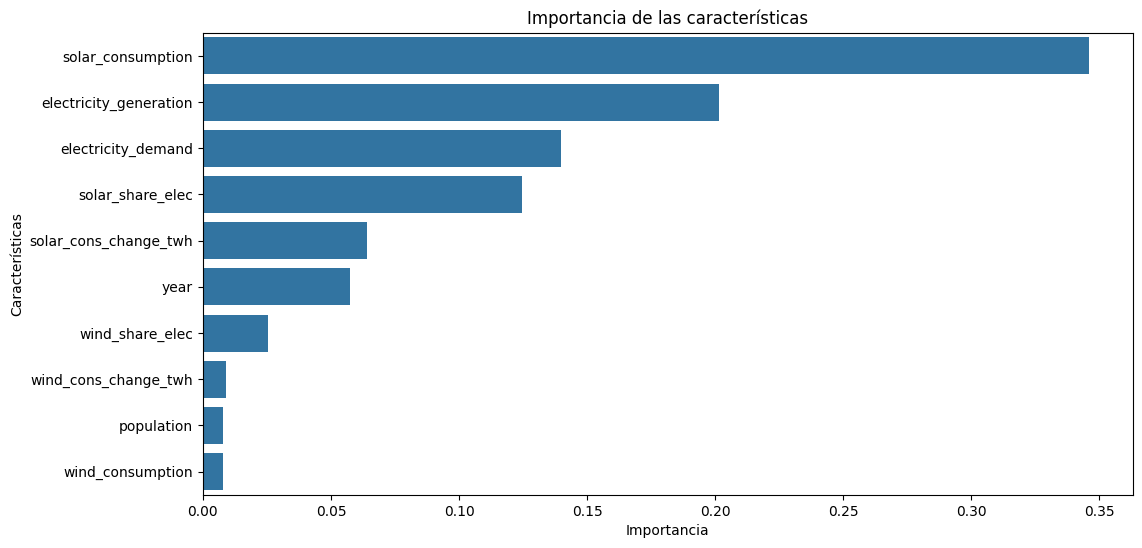

In [13]:
# 12. Importancia de las características
importances = model.estimators_[0].feature_importances_
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances["Importance"].head(10), y=feature_importances.index[:10])
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



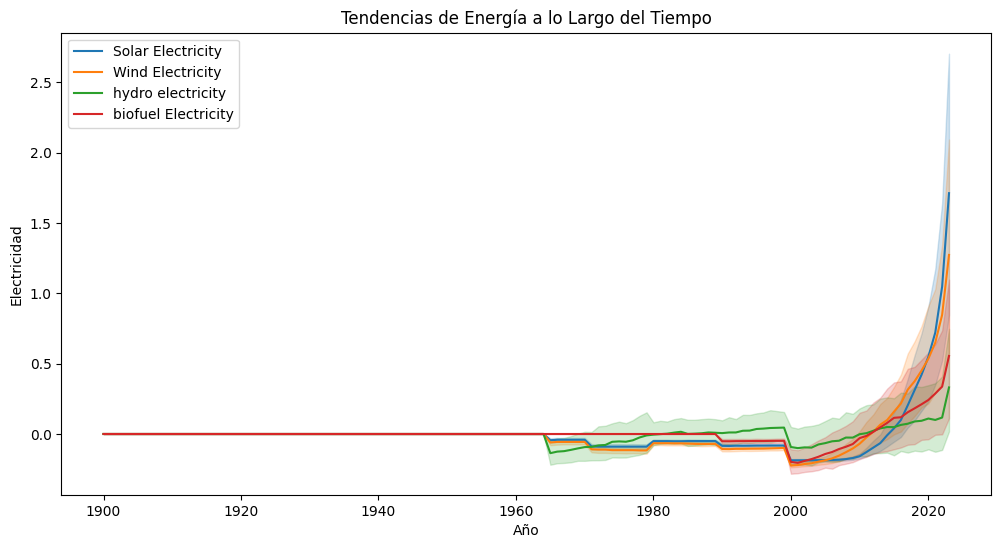

In [18]:
# 13. Tendencias de energía a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='solar_electricity', label='Solar Electricity')
sns.lineplot(data=df, x='year', y='wind_electricity', label='Wind Electricity')
sns.lineplot(data=df, x='year', y='hydro_electricity', label='hydro electricity')
sns.lineplot(data=df, x='year', y='biofuel_electricity', label='biofuel Electricity')
plt.title('Tendencias de Energía a lo Largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Electricidad')
plt.legend()
plt.show()


In [15]:
# 14. Guardar el modelo
dump(grid_search, 'model/energy_model_seap.joblib')

# Guardar los nombres de las características usadas durante el entrenamiento
features = X_train.columns.tolist()  # Obtener las columnas del conjunto de entrenamiento
dump(features, 'model/energy_model_features.joblib')  # Guardar las características
# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/energy_model_features_columns.txt'
with open(features_filepath, 'w') as f:
    for column in X.columns:
        f.write(f"{column}\n")

In [34]:
columns_of_interest = [
    'year', 'country', 'iso_code', 'population', 'gdp', 
    'electricity_demand', 'electricity_generation', 'electricity_share_energy',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 
    'solar_consumption', 'wind_consumption', 'biofuel_consumption', 
    'solar_cons_change_twh', 'wind_cons_change_twh', 
    'biofuel_cons_change_pct', 'solar_share_elec', 'wind_share_elec'
]

# Filtrar el DataFrame
filtered_data = df[columns_of_interest]

# Obtener estadísticas descriptivas
statistics = filtered_data.describe()

# Mostrar las estadísticas
display(statistics)

,year,country,iso_code,population,gdp,electricity_demand,electricity_generation,electricity_share_energy,energy_cons_change_twh,energy_per_capita,energy_per_gdp,solar_consumption,wind_consumption,biofuel_consumption,solar_cons_change_twh,wind_cons_change_twh,biofuel_cons_change_pct,solar_share_elec,wind_share_elec
count,21812.000000,2.181200e+04,2.181200e+04,21812.000000,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04,2.181200e+04
mean,1974.195718,1.667880e-16,1.667880e-16,0.000000,1.042425e-17,5.212123e-18,-2.736365e-17,-2.353274e-15,-3.648486e-17,2.606062e-17,-1.824243e-16,3.387880e-17,3.387880e-17,1.042425e-17,-4.039396e-17,2.215152e-17,8.380117e-17,4.560608e-17,6.775761e-17
std,35.342860,1.000023e+00,1.000023e+00,1.000023,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,1900.000000,-1.694203e+00,-1.785087e+00,-0.245677,-1.652175e-01,-4.764398e-01,-5.160525e-01,-4.999462e+00,-1.726933e+01,-1.021663e+00,-1.654604e+00,-3.257229e-01,-4.164785e-01,-9.255567e-01,-6.416152e-01,-3.164578e+00,-1.900404e+00,-5.398093e-01,-5.540919e-01
25%,1946.000000,-8.932250e-01,-9.105355e-01,-0.239639,-1.507380e-01,0.000000e+00,-4.279481e-01,-2.357949e-15,-2.446863e-01,-4.512915e-01,-2.155751e-16,4.364677e-17,4.927148e-17,0.000000e+00,-5.418733e-17,4.786990e-17,9.281192e-17,-4.168824e-01,-3.651544e-01
50%,1984.000000,6.194821e-04,1.389259e-01,-0.221922,2.367735e-17,0.000000e+00,0.000000e+00,-2.357949e-15,-3.986040e-17,0.000000e+00,-2.155751e-16,4.364677e-17,4.927148e-17,0.000000e+00,-5.418733e-17,4.786990e-17,9.281192e-17,7.754329e-17,8.246201e-17
75%,2004.000000,8.480305e-01,1.107660e+00,-0.012264,2.367735e-17,0.000000e+00,0.000000e+00,-2.357949e-15,-3.986040e-17,0.000000e+00,-2.155751e-16,4.364677e-17,4.927148e-17,0.000000e+00,-5.418733e-17,4.786990e-17,9.281192e-17,7.754329e-17,8.246201e-17
max,2023.000000,1.707050e+00,1.174933e+00,18.506549,5.030924e+01,2.245692e+01,1.897502e+01,1.755186e+01,2.473716e+01,2.493844e+01,2.278690e+01,5.206275e+01,4.146945e+01,3.027859e+01,4.955664e+01,3.610743e+01,7.332861e+01,3.438258e+01,2.088024e+01


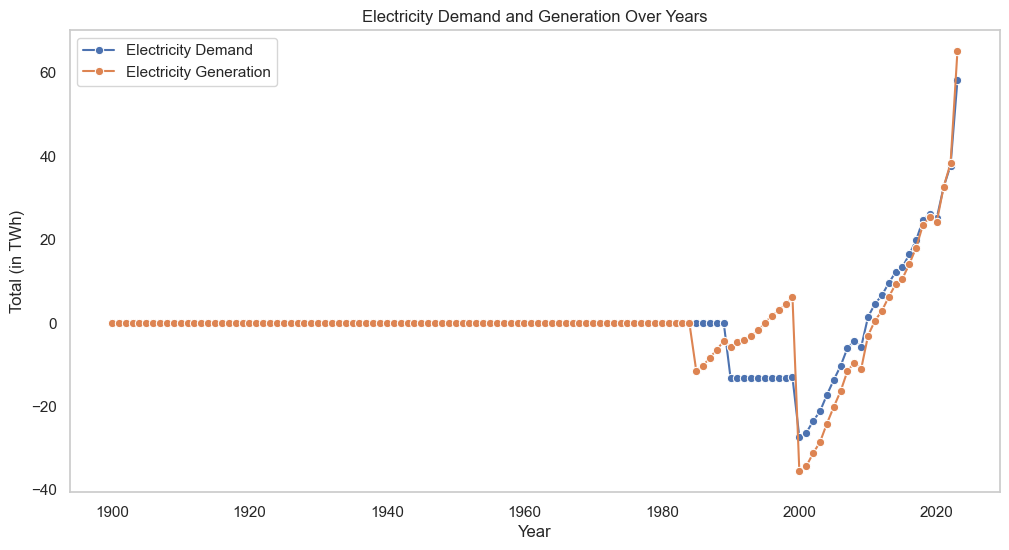

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19712\1539300008.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=consumption_data, x='Energy Source', y='Total Consumption (TWh)', palette='viridis')


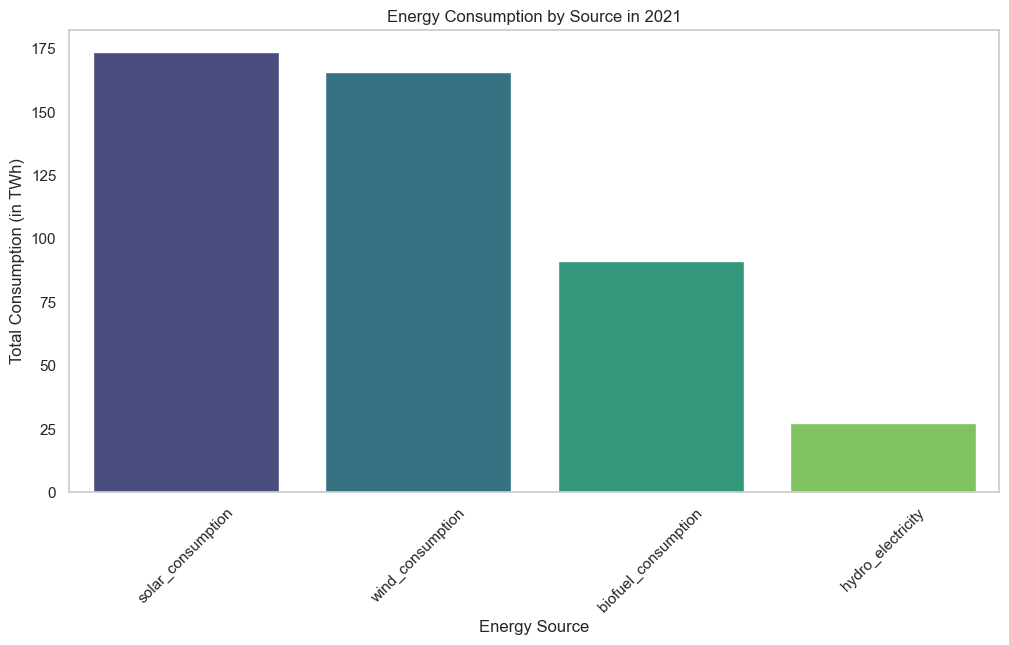

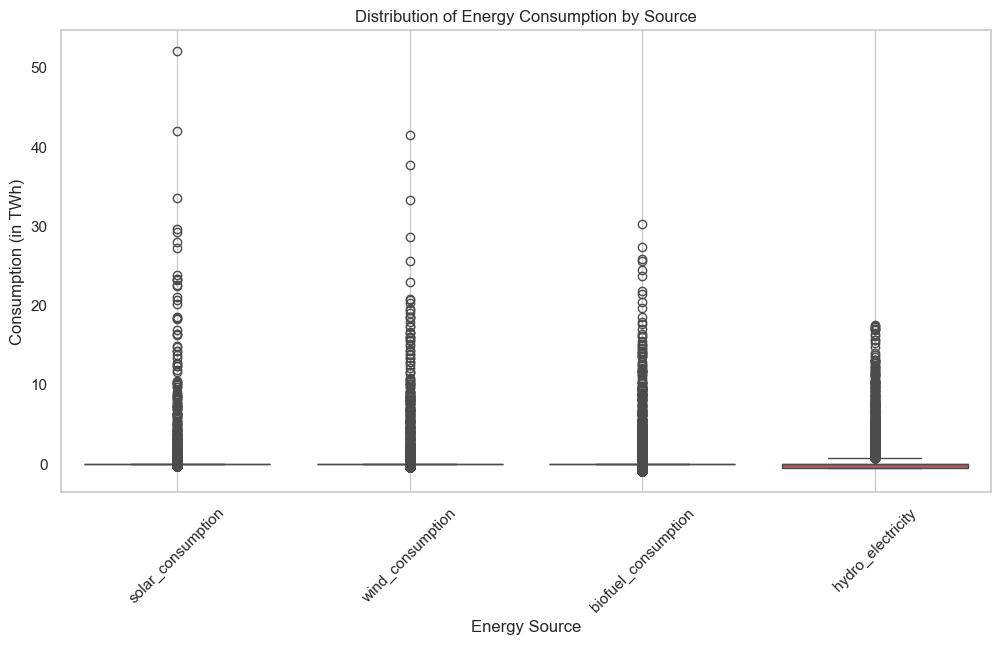

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv('data/clean/cleaned_data.csv')

# Establecer el estilo de seaborn
sns.set(style='whitegrid')

# 1. Gráfico de Barras de la Demanda y Generación de Electricidad por Año
filtered_data = data[['year', 'electricity_demand', 'electricity_generation']]
yearly_data = filtered_data.groupby('year').sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x='year', y='electricity_demand', label='Electricity Demand', marker='o')
sns.lineplot(data=yearly_data, x='year', y='electricity_generation', label='Electricity Generation', marker='o')
plt.title('Electricity Demand and Generation Over Years')
plt.xlabel('Year')
plt.ylabel('Total (in TWh)')
plt.legend()
plt.grid()
plt.show()


# 3. Gráfico de Barras de Consumo de Energía por Tipo para el año 2021
specific_year_data = data[data['year'] == 2021]
energy_sources = ['solar_consumption', 'wind_consumption', 'biofuel_consumption', 'hydro_electricity']
consumption_data = specific_year_data[energy_sources].sum().reset_index()
consumption_data.columns = ['Energy Source', 'Total Consumption (TWh)']

plt.figure(figsize=(12, 6))
sns.barplot(data=consumption_data, x='Energy Source', y='Total Consumption (TWh)', palette='viridis')
plt.title('Energy Consumption by Source in 2021')
plt.xlabel('Energy Source')
plt.ylabel('Total Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 4. Gráfico de Caja de Consumo de Energía por Fuente
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[energy_sources])
plt.title('Distribution of Energy Consumption by Source')
plt.xlabel('Energy Source')
plt.ylabel('Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


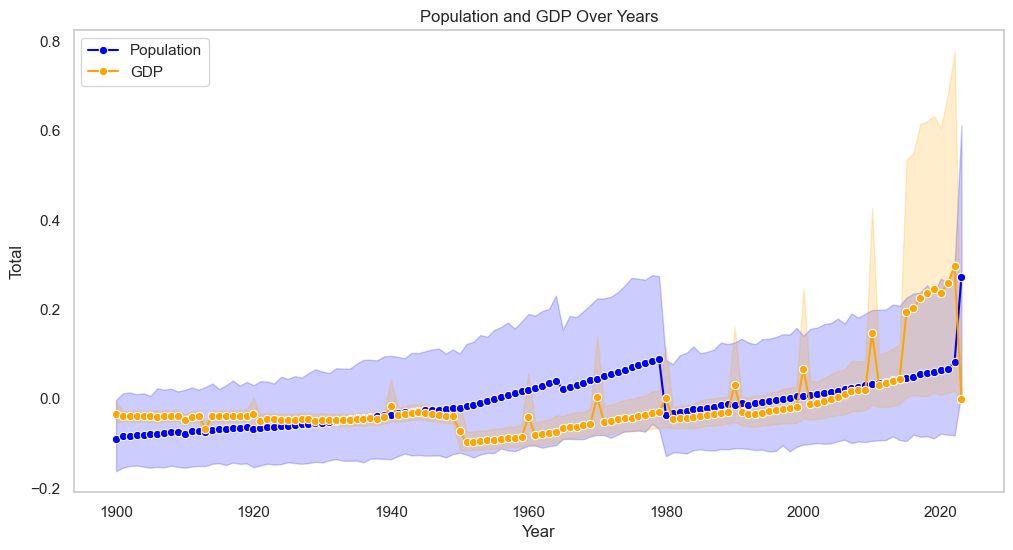

In [39]:
# Establecer el estilo de seaborn
sns.set(style='whitegrid')

# 1. Gráfico de Línea de Población y PIB a lo Largo de los Años
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='year', y='population', label='Population', color='blue', marker='o')
sns.lineplot(data=data, x='year', y='gdp', label='GDP', color='orange', marker='o')
plt.title('Population and GDP Over Years')
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.grid()
plt.show()


In [42]:
import geopandas as gpd

# Filtrar las columnas necesarias
data_map = data[['country', 'iso_code', 'electricity_demand']].groupby('country').mean().reset_index()

# Cargar el mapa mundial
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Hacer merge de los datos de electricidad con el mapa mundial
world = world.merge(data_map, left_on='name', right_on='country', how='left')

# Crear el gráfico
plt.figure(figsize=(15, 10))
world.boundary.plot()
world.plot(column='electricity_demand', cmap='OrRd', legend=True,
           legend_kwds={'label': "Electricity Demand (in TWh)",
                        'orientation': "horizontal"},
           missing_kwds={'color': 'lightgrey', 'label': 'No data'})
plt.title('Global Electricity Demand by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

ModuleNotFoundError: No module named 'geopandas'

Código original sin gráficos

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from functions2 import load_and_clean_data

# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# 2. Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# 3. Aplicar Label Encoding a las columnas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Separar características y variables objetivo
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

# 5. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# 7. Entrenar el modelo
model.fit(X_train, y_train)

# 8. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

# Obtener las importancias de las características
importances = model.estimators_[0].feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Seleccionar características importantes
important_threshold = 0.01
selected_features = feature_importances[feature_importances["Importance"] > important_threshold].index.tolist()

# Crear nuevo DataFrame con características seleccionadas
X_selected = X[selected_features]

# Dividir los datos nuevamente
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Definir el modelo nuevamente
model_selected = MultiOutputRegressor(RandomForestRegressor())

# Entrenar el modelo
model_selected.fit(X_train_selected, y_train)

# Hacer predicciones
y_pred_selected = pd.DataFrame(model_selected.predict(X_test_selected), columns=target_columns)

# Calcular métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_selected)
rmse = mean_squared_error(y_test, y_pred_selected, squared=False)
r2 = r2_score(y_test, y_pred_selected)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Realizar validación cruzada
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_cv = -cv_scores.mean()

print(f"MAE (Validación Cruzada): {mae_cv:.4f}")

# Definir el espacio de hiperparámetros para Random Forest
from sklearn.model_selection import GridSearchCV
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


In [16]:
'''

# Importar librerías
import pandas as pd
from joblib import load
from functions_3 import plot_predictions_vs_actual, plot_feature_importance, plot_time_series
from sklearn.model_selection import train_test_split

# 1. Cargar el dataset original
df = pd.read_csv('data/raw/owid-energy-data.csv')

# Eliminar las columnas innecesarias como 'iso_code' pero mantener 'country'
df = df.drop(columns=['iso_code'])

# Definir las columnas objetivo (tipos de energía)
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']

# Separar características (X) y variables objetivo (y)
X = df.drop(columns=target_columns)
y = df[target_columns]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/features.txt'
with open(features_filepath, 'w') as f:
    for column in X_train.columns:
        f.write(f"{column}\n")

# 2. Cargar el modelo entrenado desde la carpeta model
model_filepath = 'model/random_forest_seap.joblib'
model = load(model_filepath)

# Cargar las características utilizadas durante el entrenamiento
with open(features_filepath, 'r') as f:
    features = [line.strip() for line in f]

# Asegurarse de que X_test contenga solo las columnas usadas en el entrenamiento
X_test = X_test[features]

# Example of adding missing features
for feature in features:
    if feature not in X_test.columns:
        X_test[feature] = 0  # Or np.nan if appropriate

print("Adjusted Test Features:", X_test.columns)  # Check again

# 3. Obtener las predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# 4. Graficar Predicciones vs Valores Reales
plot_predictions_vs_actual(y_test, y_pred, target_columns)

# 5. Mostrar Importancia de Características
importances = model.estimators_[0].feature_importances_
feature_names = X_test.columns
plot_feature_importance(importances, feature_names)

# 6. Graficar Series de Tiempo por País (aquí usamos la columna 'country')
energy_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
plot_time_series(df[['country'] + energy_columns], energy_columns)

# 7. Ver número de columnas después de la limpieza
print(f"Número de columnas después de la limpieza: {df.shape[1]}")
print("Columnas después de la limpieza:", df.columns.tolist())

# 8. Ver número de columnas utilizadas por el modelo
print(f"Número de columnas utilizadas por el modelo: {X_train.shape[1]}")
print("Columnas utilizadas por el modelo:", X_train.columns.tolist())


'''

'\n\n# Importar librerías\nimport pandas as pd\nfrom joblib import load\nfrom functions_3 import plot_predictions_vs_actual, plot_feature_importance, plot_time_series\nfrom sklearn.model_selection import train_test_split\n\n# 1. Cargar el dataset original\ndf = pd.read_csv(\'data/raw/owid-energy-data.csv\')\n\n# Eliminar las columnas innecesarias como \'iso_code\' pero mantener \'country\'\ndf = df.drop(columns=[\'iso_code\'])\n\n# Definir las columnas objetivo (tipos de energía)\ntarget_columns = [\'solar_electricity\', \'wind_electricity\', \'hydro_electricity\', \'biofuel_electricity\']\n\n# Separar características (X) y variables objetivo (y)\nX = df.drop(columns=target_columns)\ny = df[target_columns]\n\n# Dividir en conjuntos de entrenamiento y prueba\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Guardar las columnas utilizadas para el modelo\nfeatures_filepath = \'model/features.txt\'\nwith open(features_filepath, \'w\') as f:\n 

import joblib

# Cargar el modelo
loaded_model = joblib.load('model/random_forest_seap.joblib')

# Obtener el número de columnas
num_columnas = loaded_model.n_features_in_
print("El modelo usó", num_columnas, "columnas.")